In [67]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy.io as sio
import os
import ieeg_funcs as ief
import dgFuncs as dg
import pickle as pickle
from sklearn import svm
from sklearn.externals import joblib

In [68]:
# Load model
model_name='smart_srch_small2'
path_dict=ief.get_path_dict()
model_path='/home/dgroppe/GIT/SZR_ANT/MODELS/'
in_file=os.path.join(model_path,model_name,'classify_models_srch.pkl')
print('Loading %s' % in_file)
best_models=pickle.load(open(in_file,'rb'))
best_models.keys()
type(best_models[0])
n_models=len(best_models)
print('%d total classifiers' % n_models)

# Load performance metrics and model parameters
in_file=os.path.join('/home/dgroppe/GIT/SZR_ANT/MODELS/',model_name,'classify_metrics_srch.npz')
metrics=np.load(in_file)
ftr_types=metrics['ftr_types']
print('Features being used: {}'.format(ftr_types))
metrics.keys()


Loading /home/dgroppe/GIT/SZR_ANT/MODELS/smart_srch_small2/classify_models_srch.pkl
8 total classifiers
Features being used: ['PWR' 'PWR_3SEC' 'PWRSTD_3SEC' 'PWR_9SEC' 'VLTG' 'VLTG_3SEC'
 'VLTGSTD_3SEC']


['valid_sens',
 'valid_spec',
 'valid_bal_acc',
 'train_sens',
 'train_spec',
 'train_bal_acc',
 'train_subs_list',
 'mn_stim_latency',
 'pptn_missed_szrs',
 'pptn_preonset_stim',
 'n_train_steps',
 'rand_ct',
 'C_vals',
 'gamma_vals',
 'best_valid_bal_acc',
 'best_C',
 'best_gam',
 'best_models',
 'ftr_types',
 'left_out_id']

In [69]:
# Import held out sub data
sub='NA'

# Get list of data files for this sub
n_ftr_types=len(ftr_types)
n_dim=0
n_wind_list=[]
stem_list=[]
grand_ftr_list=[]
for type_ct, ftr_type in enumerate(ftr_types):
    print('Checking dimensions of feature type %s' % ftr_type)
    # Figure out how much data there is to preallocate mem
    ftr_type_dir=os.path.join(path_dict['ftrs_root'],ftr_type)

    if type_ct==0:
        # count time windows and create fname_stem_list
        stem_list = []
        ftr_path=os.path.join(ftr_type_dir,sub)
        for f in os.listdir(ftr_path):
            #get file stem
            f_parts = f.split('_')
            f_stem = f_parts[0]+'_'+f_parts[1]+'_'+f_parts[2]
            #fname_stem_list.append(f_stem)
            stem_list.append(f_stem)
            ftr_dict=np.load(os.path.join(ftr_path,f))
            #n_wind+=np.sum(ftr_dict['peri_ictal']>=0)
            n_wind_list.append(ftr_dict['ftrs'].shape[1])
    else:
        temp_n_wind=0
        f_ct=0
        # Load file extension
        ext_fname = os.path.join(ftr_type_dir, 'ext.txt')
        with open(ext_fname, 'r') as f_ext:
            ext = f_ext.readline()[:-1]
        print(ext_fname)
        print(ext)
        ftr_path=os.path.join(ftr_type_dir,sub)
        for temp_stem_ct, temp_stem in enumerate(stem_list):
            targ_file=os.path.join(ftr_path,temp_stem+ext)
            # if os.path.isfile(targ_file)==False:
            #     print('File not found: %s' % targ_file)
            #     raise ValueError('File stems do not match across features')
            print('Loading file %s' % targ_file)
            ftr_dict=np.load(targ_file)
            f_ct+=1
        if n_wind_list[temp_stem_ct]!=ftr_dict['ftrs'].shape[1]:
            raise ValueError('# of time windows do not match across features')
    n_dim += ftr_dict['ftrs'].shape[0]
    for ftr_label in ftr_dict['ftr_list']:
        grand_ftr_list.append(ftr_label)
    #grand_ftr_list.append(ftr_dict['ftr_list'])

print('Total # of dimensions: %d ' % n_dim)
print('Total # of time windows: {} '.format(n_wind_list))
print('Total # of files: %d' % f_ct)
print(grand_ftr_list)

Checking dimensions of feature type PWR
Checking dimensions of feature type PWR_3SEC
/home/dgroppe/GIT/SZR_ANT/FTRS/PWR_3SEC/ext.txt
_bppwr_3sec.npz
Loading file /home/dgroppe/GIT/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d1_sz4_bppwr_3sec.npz
Loading file /home/dgroppe/GIT/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d1_sz2_bppwr_3sec.npz
Loading file /home/dgroppe/GIT/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d1_sz5_bppwr_3sec.npz
Loading file /home/dgroppe/GIT/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d2_sz1_bppwr_3sec.npz
Loading file /home/dgroppe/GIT/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d1_sz3_bppwr_3sec.npz
Checking dimensions of feature type PWRSTD_3SEC
/home/dgroppe/GIT/SZR_ANT/FTRS/PWRSTD_3SEC/ext.txt
_bppwr_std3sec.npz
Loading file /home/dgroppe/GIT/SZR_ANT/FTRS/PWRSTD_3SEC/NA/NA_d1_sz4_bppwr_std3sec.npz
Loading file /home/dgroppe/GIT/SZR_ANT/FTRS/PWRSTD_3SEC/NA/NA_d1_sz2_bppwr_std3sec.npz
Loading file /home/dgroppe/GIT/SZR_ANT/FTRS/PWRSTD_3SEC/NA/NA_d1_sz5_bppwr_std3sec.npz
Loading file /home/dgroppe/GIT/SZR_ANT/FTRS/PWRSTD_3SEC/NA/NA_d2_sz

Loading /home/dgroppe/GIT/SZR_ANT/FTRS/PWR/NA/NA_d1_sz4_bppwr.npz
Loading /home/dgroppe/GIT/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d1_sz4_bppwr_3sec.npz
Loading /home/dgroppe/GIT/SZR_ANT/FTRS/PWRSTD_3SEC/NA/NA_d1_sz4_bppwr_std3sec.npz
Loading /home/dgroppe/GIT/SZR_ANT/FTRS/PWR_9SEC/NA/NA_d1_sz4_bppwr_9sec.npz
Loading /home/dgroppe/GIT/SZR_ANT/FTRS/VLTG/NA/NA_d1_sz4_vltg.npz
Loading /home/dgroppe/GIT/SZR_ANT/FTRS/VLTG_3SEC/NA/NA_d1_sz4_vltg_3sec.npz
Loading /home/dgroppe/GIT/SZR_ANT/FTRS/VLTGSTD_3SEC/NA/NA_d1_sz4_vltg_std3sec.npz
Applying model 1/8
Applying model 2/8
Applying model 3/8
Applying model 4/8
Applying model 5/8
Applying model 6/8
Applying model 7/8
Applying model 8/8
39 dimensions
2710 observations
Creating file /home/dgroppe/GIT/SZR_ANT/MODELS/PICS/NA_d1_sz4.jpg
Loading /home/dgroppe/GIT/SZR_ANT/FTRS/PWR/NA/NA_d1_sz2_bppwr.npz
Loading /home/dgroppe/GIT/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d1_sz2_bppwr_3sec.npz
Loading /home/dgroppe/GIT/SZR_ANT/FTRS/PWRSTD_3SEC/NA/NA_d1_sz2_bppwr_std3sec.npz
Lo

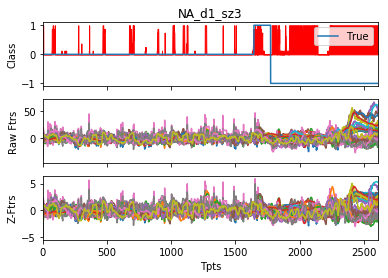

In [97]:
# Load validation data and calculate false positive rate, and peri-onset latency
onset_dif_sec_list=list()
n_missed_szrs=0
pptn_preonset_stim=0
mn_onset_dif=0
n_szrs=len(stem_list)
stim_delay=np.zeros(n_szrs)
false_pos_rate=np.zeros(n_szrs)
specificity=np.zeros(n_szrs)
phat_list=[]
#for stem_ct, stem_loop in enumerate(stem_list[:1]):
for stem_ct, stem_loop in enumerate(stem_list):
    # Collect features for each seizure
    dim_ct=0
    phat_list.append(np.zeros((n_wind_list[stem_ct],n_models)))
    for ftr_type in ftr_types:
        ftr_path = os.path.join(path_dict['ftrs_root'], ftr_type, sub)
        file_found=False
        for f_valid in os.listdir(ftr_path):
            # get file stem
            f_parts = f_valid.split('_')
            temp_f_stem = f_parts[0] + '_' + f_parts[1] + '_' + f_parts[2]
            if temp_f_stem==stem_loop:
                # load file
                #print('Loading %s' % f)
                print('Loading %s' % os.path.join(ftr_path, f_valid))
                ftr_dict = np.load(os.path.join(ftr_path, f_valid))
                file_found=True
                # break out of for loop
                break
        # Catch if new file was not loaded
        if not file_found:
            print('Trying to find %s for %s' % (stem_loop,ftr_type))
            print('Looking in dir %s' % ftr_path)
            raise ValueError('File stem not found')
            exit()
        # Add ftr to collection
        temp_n_dim = ftr_dict['ftrs'].shape[0]
        # Note that we use all time points (even ictal points long after ictal onset
        if ftr_type==ftr_types[0]:
            # First feature being analyzed pre-allocate mem
            temp_n_wind=ftr_dict['ftrs'].shape[1]
            temp_valid_ftrs=np.zeros((temp_n_wind,n_dim))
        temp_valid_ftrs[:, dim_ct:dim_ct + temp_n_dim] = ftr_dict['ftrs'].T
        dim_ct += temp_n_dim

    for model_ct in range(n_models):
        # Load model
#         model_fname=os.path.join(model_path,model_list[model_ct])
#         temp_model=joblib.load(model_fname)
#         # Classify each time point
#         print('Applying model %d/%d' % (model_ct+1,n_models))
#         temp_class_hat=temp_model.predict(temp_valid_ftrs) 
        # Classify each time point
        print('Applying model %d/%d' % (model_ct+1,n_models))
        temp_class_hat=best_models[model_ct].predict(temp_valid_ftrs) 
        phat_list[stem_ct][:,model_ct]=temp_class_hat
    
    # Average predictions across all models and take the majority vote
    temp_class_hat=np.mean(phat_list[stem_ct],axis=1)
    temp_class_hat_bool=temp_class_hat>0.5
    plot_fig(ftr_dict['peri_ictal'],temp_class_hat,temp_valid_ftrs,stem_loop,stem_ct,model_path)
    
    # Compute false positive rate
    total_windows=np.sum(ftr_dict['peri_ictal']==0)
    total_sec=total_windows*sgram_srate
    total_fp=np.sum(temp_class_hat_bool[ftr_dict['peri_ictal']==0])
    false_pos_rate[stem_ct]=total_fp/total_sec
    specificity[stem_ct]=1-np.mean(temp_class_hat_bool[ftr_dict['peri_ictal']==0])
    
    # Compute latency of earliest ictal prediction relative to clinician onset
    sgram_srate=1/10
    onset_dif_sec, preonset_stim=ief.cmpt_postonset_stim_latency(temp_class_hat_bool,ftr_dict['peri_ictal'],sgram_srate)
    pptn_preonset_stim+=preonset_stim/f_ct
    if onset_dif_sec is None:
        # no positives during peri-onset time window
        n_missed_szrs+=1
        stim_delay[stem_ct]=np.nan()
    else:
        mn_onset_dif+=onset_dif_sec
        stim_delay[stem_ct]=onset_dif_sec
    
pptn_missed_szrs = n_missed_szrs/f_ct
if n_missed_szrs==f_ct:
    mn_stim_latency = np.nan
else:
    mn_stim_latency= mn_onset_dif/(f_ct-n_missed_szrs)
    
print('Proportion of missed szrs: %f ' % pptn_missed_szrs)
print('Proportion of szrs with pre-onset stimulation: %f ' % pptn_preonset_stim)
print('Mean postonset stim latency %f' % mn_stim_latency)
out_fname=os.path.join(model_path,'smry.npz')
np.savez(out_fname,
         pptn_missed_szrs=pptn_missed_szrs,
         pptn_preonset_stim=pptn_preonset_stim,
         mn_stim_latency=mn_stim_latency,
         sub=sub,
         grand_ftr_list=grand_ftr_list)

In [98]:
#temp_class_hat_bool,ftr_dict['peri_ictal']
total_windows=np.sum(ftr_dict['peri_ictal']==0)
print(total_windows)
print(total_windows*sgram_srate)
print(np.sum(temp_class_hat_bool[ftr_dict['peri_ictal']==0]))
print(np.mean(temp_class_hat_bool[ftr_dict['peri_ictal']==0]))
print(np.sum(temp_class_hat_bool[ftr_dict['peri_ictal']==0])/total_windows)
print('MN [SD] false pos rate: %f [%f]' % (np.mean(false_pos_rate),np.std(false_pos_rate)))
print('MN [SD] specificity: %f [%f]' % (np.mean(specificity),np.std(specificity)))
print(false_pos_rate)

1645
164.5
138
0.0838905775076
0.0838905775076
MN [SD] false pos rate: 0.980236 [0.416082]
MN [SD] specificity: 0.901976 [0.041608]
[ 0.4548105   0.69955157  1.59882006  1.30909091  0.83890578]


In [90]:
total_windows=np.sum(ftr_dict['peri_ictal']==0)
total_sec=total_windows*sgram_srate
total_fp=np.sum(temp_class_hat_bool[ftr_dict['peri_ictal']==0])
print(total_sec)
print(total_fp)
print(total_fp/total_sec)

164.5
138
0.838905775076


In [78]:
print(n_missed_szrs)
print(pptn_missed_szrs)
print(onset_dif_sec)
print(stim_delay)
print('MEAN [SD] stimulation delay: %f [%f]' % (np.mean(stim_delay),np.std(stim_delay)))
mn_stim_latency

0
0.0
0.7
[ 4.3  3.2  2.8  5.8  0.7]
MEAN [SD] stimulation delay: 3.360000 [1.688313]


3.3600000000000003

In [64]:
def plot_fig(true_class,hat_class,ftr_vals,stem,fig_ct,model_dir):
    n_wind=len(hat_class)
    plt.figure(1)
    plt.clf()
    plt.subplot(3,1,1)
    plt.plot(true_class,label='True')
    plt.fill_between(np.arange(n_wind),0,hat_class,color='r')
    #plt.fill_between(np.arange(len(hat_class)),0,hat_class,'r',label='Hat')
    plt.ylabel('Class')
    plt.legend()
    plt.gca().xaxis.set_ticklabels([])
    plt.title(stem)
    plt.xlim([0, n_wind])
    
    plt.subplot(3,1,2)
    _=plt.plot(ftr_vals)
    plt.ylabel('Raw Ftrs')
    plt.gca().xaxis.set_ticklabels([])
    plt.xlim([0, n_wind])
    
    temp_valid_ftrs_z=np.copy(ftr_vals).T
    dg.normalize(temp_valid_ftrs_z)
    plt.subplot(3,1,3)
    _=plt.plot(temp_valid_ftrs_z.T)
    #plt.xlabel('Seconds')
    plt.xlabel('Tpts')
    plt.ylabel('Z-Ftrs')
    plt.xlim([0, n_wind])
    
    fig_path=os.path.join(model_path,'PICS')
    if os.path.exists(fig_path)==False:
        os.mkdir(fig_path)
    fig_fname=os.path.join(fig_path,stem+'.jpg')
    print('Creating file %s' % fig_fname)
    plt.savefig(fig_fname,format='jpg')

39 dimensions
2610 observations
Creating file /home/dgroppe/GIT/SZR_ANT/MODELS/PICS/NA_d1_sz3.jpg


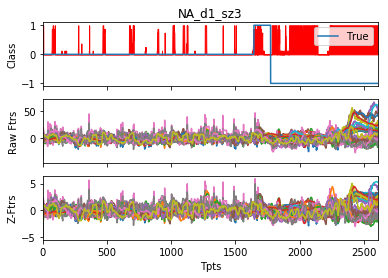

In [99]:
plot_fig(ftr_dict['peri_ictal'],temp_class_hat,temp_valid_ftrs,stem_loop,stem_ct,model_path)

In [5]:
#ftrs=np.load('temp_data_ensemb.npz')
ftrs=np.load('temp_ftrs.npz')
ftrs.keys()

['sub_id', 'szr_class', 'ftrs']

In [111]:
chan_labels=ief.import_chan_labels('NA')
for ct, chan_lab in enumerate(chan_labels):
    print('%d: %s' % (ct,chan_lab))
#print(chan_labels)

Loading /home/dgroppe/TWH_EEG/NA/NA_channel_info.csv
0: LHD1-2
1: LHD2-3
2: LHD3-4
3: LAT1-2
4: LAT2-3
5: LAT3-4
6: LMT1-2
7: LMT2-3
8: LMT3-4
9: LPT1-2
10: LPT2-3
11: LPT3-4
12: RHD1-2
13: RHD2-3
14: RHD3-4
15: RAT1-2
16: RAT2-3
17: RAT3-4
18: RMT1-2
19: RMT2-3
20: RMT3-4
21: RSPT1-2
22: RSPT2-3
23: RSPT3-4
24: RSPT4-5
25: RSPT5-6
26: RIPT1-2
27: RIPT2-3
28: RIPT3-4
29: RIPT4-5
30: RIPT5-6


In [116]:

print(phat_sec[-1])
print(tpts_sec[-1])

270.9
271.998


In [118]:
   wind_len=Sf
        wind_step=Sf/10
        n_tapers=4
        sgram, f, sgram_sec=ief.mt_sgram(ieeg[onset_chan_id,:],Sf,wind_len,wind_step,n_tapers,tpts_sec)
        cutoff_freq=Sf*.4 # remove frequencies above anti-aliasing filter cutoff
        f=f[f<=cutoff_freq]
        n_freq=len(f)
        sgram=sgram[:n_freq,:]
        n_wind=len(sgram_sec)

(2710, 8)

Loading /home/dgroppe/TWH_EEG/NA/EEG_MAT/NA_d1_sz4.mat
201 dimensions
2710 observations


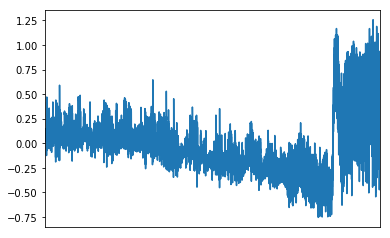

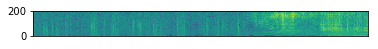

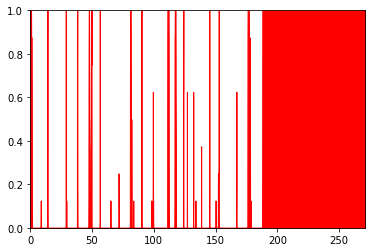

In [171]:
onset_chan_id=12
wind_len=1
wind_step=0.1
for stem_ct, stem_loop in enumerate(stem_list[:1]):
#for stem_ct, stem_loop in enumerate(stem_list):
    # Get center of phat time windows for plotting:
    n_phat=phat_list[0].shape[0]
    phat_sec=np.arange(0,n_phat)/10

    # Load raw data
    in_file=stem_loop+'.mat'
    ieeg, Sf, tpts_sec=ief.import_ieeg('NA_d1_sz4.mat')
    
    # Convert onset channel data to spectrogram
    wind_len=Sf
    wind_step=Sf/10
    n_tapers=4
    sgram, f, sgram_sec=ief.mt_sgram(ieeg[onset_chan_id,:],Sf,wind_len,wind_step,n_tapers,tpts_sec)
    cutoff_freq=Sf*.4 # remove frequencies above anti-aliasing filter cutoff
    f=f[f<=cutoff_freq]
    n_freq=len(f)
    sgram=sgram[:n_freq,:]
    n_wind=len(sgram_sec)
    dg.trimmed_normalize(sgram,0.4)
    
    # Plot all three along with predictions
    plt.figure(1)
    plt.clf()
#     ax=plt.subplot(3,1,1)
    plt.plot(tpts_sec,ieeg[onset_chan_id,:])
    plt.xlim(phat_sec[0],phat_sec[-1])
    plt.xticks([])
    #plt.gca().xaxis.set_ticklabels([])
#     pos1=ax.get_position()
#     pos1.y0-=0.03
#     ax.set_position(pos1)
    
    plt.figure(2)
    plt.clf()
    #plt.subplot(3,1,2)
    abs_mx=np.max(np.abs(sgram))
    plt.imshow(sgram,vmin=-abs_mx,vmax=abs_mx)
    plt.gca().invert_yaxis()
    plt.xticks([])
#     ax2=plt.gca()
#     pos2=ax2.get_position()
#     pos2.y0-=.08
#     pos2.y1+=.2
#     ax2.set_position(pos2)
    
    #plt.subplot(3,1,3)
    plt.figure(3)
    plt.clf()
    plt.fill_between(phat_sec,np.mean(phat_list[stem_ct],axis=1),color='r')
    #plt.fill_between(np.arange(n_wind),0,hat_class,color='r')
    plt.xlim(phat_sec[0],phat_sec[-1])
    plt.ylim(0,1)
    

In [170]:
print(pos2)
print(pos2.y0)
print(pos2.y1)

Bbox(x0=0.125, y0=0.3114705882352941, x1=0.9, y1=0.8135294117647058)
0.311470588235
0.813529411765


In [172]:
np.savez('NA_phat.npz',phat_list=phat_list)